# Firefighters

### Load the data

In [275]:
import numpy as np
import pandas as pd

data = pd.read_csv('../data/Firefighters.csv')  # load data set
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 5 columns):
Race        118 non-null object
Position    118 non-null object
Oral        118 non-null float64
Written     118 non-null int64
Combine     118 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 4.7+ KB


### Promoted?

Here we assume that there were 3 openings for captain and 12 for lieutenant. The top scoring 3 captain-applicants and 12 lieutenant-applicants are assigned 1 for Promoted, others 0.

In [276]:
def promoted(x):
    return 1 if ((x[0]=='Captain' and x[1] >= thresh_cpt) or (x[0]=='Lieutenant' and x[1] >= thresh_ltn)) else 0

n_cpt, n_ltn = 3, 12
thresh_cpt = min(data.groupby('Position')['Combine'].nlargest(n_cpt)['Captain'])
thresh_ltn = min(data.groupby('Position')['Combine'].nlargest(n_ltn)['Lieutenant'])
promoted = data[['Position','Combine']].apply(promoted, axis=1).rename('Promoted')
data = pd.concat([promoted, data], axis=1)

#print(thresh_cpt, thresh_ltn)
print(data.head())

   Promoted Race Position   Oral  Written  Combine
0         1    W  Captain  89.52       95   92.808
1         1    W  Captain  80.00       95   89.000
2         1    W  Captain  82.38       87   85.152
3         0    W  Captain  88.57       76   81.028
4         0    W  Captain  76.19       84   80.876


### Categorical to dummies

In [277]:
# One-Hot encoding for categorical data
for key in ['Position', 'Race']:
    dummies = pd.get_dummies(data[key]).rename(columns=lambda x: key+'_' + str(x))
    data = pd.concat([data, dummies], axis=1)
    #data.drop([key], axis=1, inplace=True)
data.head()

,Promoted,Race,Position,Oral,Written,Combine,Position_Captain,Position_Lieutenant,Race_B,Race_H,Race_W
0,1,W,Captain,89.52,95,92.808,1,0,0,0,1
1,1,W,Captain,80.00,95,89.000,1,0,0,0,1
2,1,W,Captain,82.38,87,85.152,1,0,0,0,1
3,0,W,Captain,88.57,76,81.028,1,0,0,0,1
4,0,W,Captain,76.19,84,80.876,1,0,0,0,1


### Train the model

Train a logistic regression model. Test set size 20%.

In [281]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

features = data.columns.drop(['Race', 'Position', 'Promoted']).values
X, X_test, y, y_test = train_test_split(data.iloc[:,1:], data['Promoted'], test_size=0.33, random_state=12345)

# Train
lr = LogisticRegression(class_weight = 'balanced', solver='lbfgs', max_iter=500) 
lr.fit(X[features], y)

# Predict
y_pred = lr.predict(X_test[features])

# Results data set
results = pd.DataFrame({'Predicted':y_pred, 'Actual':y_test})
results['Correct'] = results.apply(lambda x: int(x[0]==x[1]), axis=1)
results = pd.concat([results, X_test], axis=1)
results.head()

,Predicted,Actual,Correct,Race,Position,Oral,Written,Combine,Position_Captain,Position_Lieutenant,Race_B,Race_H,Race_W
54,0,0,1,B,Lieutenant,77.50,76,76.600,0,1,1,0,0
92,0,0,1,W,Lieutenant,71.67,57,62.868,0,1,0,0,1
24,0,0,1,W,Captain,71.43,68,69.372,1,0,0,0,1
102,0,0,1,W,Lieutenant,60.00,60,60.000,0,1,0,0,1
51,1,1,1,W,Lieutenant,69.58,86,79.432,0,1,0,0,1


### Results

#### Model accuracy

In [279]:
acc = sum(results['Correct'])/len(results['Correct'])
acc

0.9743589743589743

#### Predicted promotions by race

In [280]:
# Promoted by race
byrace = results.groupby(['Race', 'Predicted']).size()
print(byrace)

Race  Predicted
B     0             7
H     0             6
W     0            19
      1             7
dtype: int64


### Discriminative measures

In [316]:
def get_count(key, key2):
    if key2 in byrace[key].index.values:
        return byrace[key][key2]
    return 0

def get_predicted_count(key):
    return get_count(key, 0), get_count(key, 1)

# White
w = get_predicted_count('W')
print('White', w)

# Hispanic
h = get_predicted_count('H')
print('Hispanic', h)

# Black
b = get_predicted_count('B')
print('Black', b)

White (19, 7)
Hispanic (6, 0)
Black (7, 0)


#### Precision and recall

From wikipedia: https://en.wikipedia.org/wiki/Precision_and_recall

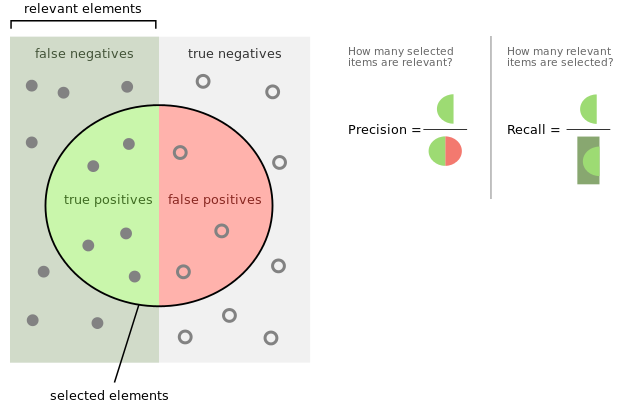

In [317]:
# Precision



